In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, DBSCAN
from kmodes.kmodes import KModes
import scipy.cluster.hierarchy as shc # for visualising AgglomerativeClustering with a dendrogram
from sklearn.metrics import silhouette_score

import bespoke_functions as f

### setup

In [2]:
x, y = datasets.make_blobs(n_samples = 1000, 
                           n_features = 2,
                           centers = 10,
                           cluster_std = 2)
df = pd.DataFrame(data = x)
df['3'] = y
df.columns = ['Feature 1', 'Feature 2', 'y']

# plt.scatter(df['feature_1'], df['feature_2'], c = df['y'])

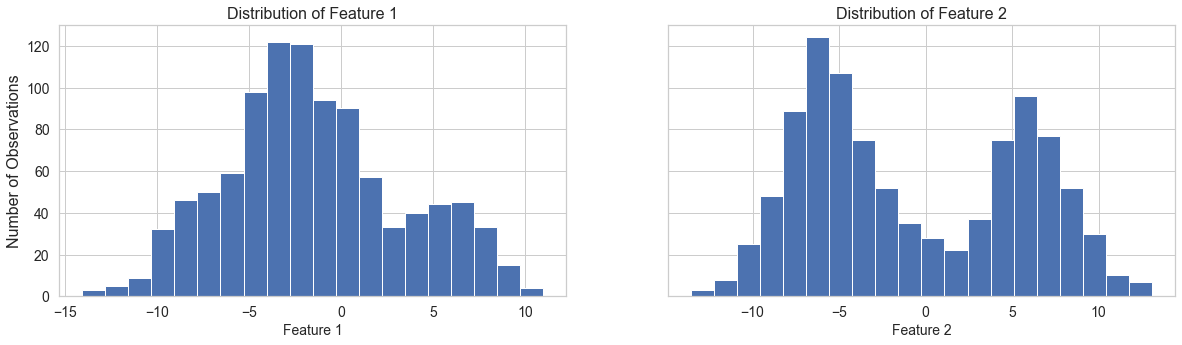

In [3]:
# visualisations
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (20,5)) # a 'figure' contains 'axes' ('axis' = graph)

ax1.set_title("Distribution of Feature 1", size = 16)
ax1.hist(df['Feature 1'], bins = 20)
ax1.set_xlabel("Feature 1", size = 14) # this is how you set x and y axis labels
ax1.set_ylabel("Number of Observations", size = 16)
ax1.tick_params(labelsize = 14)

ax2.set_title("Distribution of Feature 2", size = 16)
ax2.hist(df['Feature 2'], bins = 20)
ax2.set_xlabel("Feature 2", size = 14)
ax2.tick_params(labelsize = 14)

plt.savefig("images/distributions") # export image so we can link to it in the readme
plt.show()

In [4]:
# and how does this look in 2d space?
f.visualise(df, "Clustering Dataset", "clustering_dataset.png")

In [5]:
# these don't quite exist on the same scale, so we need to scale them. A lot of these models rely on distance between datapoints
    # (specifically, it's 'euclidian' distance - 'as the crow flies')
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled = pd.DataFrame(scaled_data, df.index, df.columns)

### KMeans

In [6]:
# kmeans is the most common clustering model, and should probably be run as a 'target to beat' when running a clustering project
# when instantiating, you tell the model how many clusters (what it calls 'centroids') there should be
# the model will place all centroids semi-randomly in a copy of your data. The steps are then as follows:
    # 1) label each datapoint with the centroid it belongs to (i.e. the nearest centroid)
    # 2) move each centroid so that it is in the middle of all its datapoints
    # 3) repeat steps 1 and 2 until there is no further movement (this is called convergence)

# the most important argument is n_clusters - it is how you set how many clusters you want.
kmeans = KMeans(n_clusters=6,
                init='k-means++', # the model will use intelligent placement of centroids to reach convergence faster
                n_init=10, # model runs this many times, the iteration which had the smallest datapoint-reassignments is used
                max_iter=300, # how many reassignments will we do in a run before giving up if we haven't reached convergence?
                tol=0.0001, # a centroid moving less than this is considered to not have moved
                precompute_distances='auto', # True is faster but uses more memory
                verbose=0, # True or False - do you want the model to print diagnostics as it goes?
                random_state=42, # this process is partially random, this number will give you consistency 
                copy_x=True, # True is faster, and also fine if we have already centered our data (standardisation)
                n_jobs=None, # how many CPU cores do you want to commit, to run iterations in parallel?
                algorithm='auto') # "auto" chooses "elkan" for dense data and "full" for sparse data

results = kmeans.fit_predict(scaled,
                             sample_weight = None) # you can alter the importance given to each feature, though this is rarely done

kmeans_output = df.copy()
kmeans_output['label'] = results

score = silhouette_score(scaled, kmeans_output['label'])

print(kmeans)
print("silhouette_score score is "+str(round(score, 3)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
silhouette_score score is 0.501


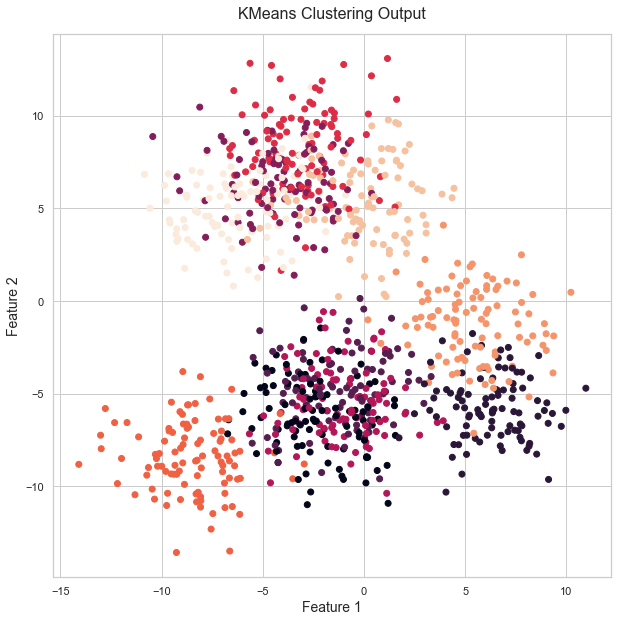

In [7]:
f.visualise(kmeans_output, "KMeans Clustering Output", "kmeans_output.png")

### K-Modes

In [8]:
# By the way, KMeans has a sister - Kmodes - and a hybrid of the two - K-prototypes.
# Kmodes is strong when all your data is booleans (kmeans works with euclidian distance and so it's not so applicable
# when your data is all 1s and 0s - which are conceptually an infinite distance apart).

# K-Modes works like this...
clf = KModes(n_clusters = 3, # you define
                 init = 'Huang', # Cao has a consideration of density
                 n_init = 1, # how many iterations do you want to do?
                 n_jobs = -2, # all cpu cores except 1
                 random_state = 42)

# mathematically, I believe it represents all your observations as vectors, and works to minimise the sum of vectors within
    # a proposed cluster.

### Affinity Propagation

In [9]:
# Affinity Propagation (AP) is both similar and different from KMeans. It's similar in that you are still focused on centroids
# (though they're now called exemplars), but it's different in that you don't choose how many clusters will be outputted.

# Methodology is as follows:
    # 1) All datapoints are computed into a 'similarity matrix', with values indicating how close together those points are
    # 2) Two matrices are made and adjusted in parallel, both consider the similarity matrix above.
        # i) a 'responsibility matrix' indicates how good an exemplar point k would be for point i, considering the availability
        #    of all the other ks
        # ii) an 'availability matrix' indicates how appropriate it is for point i to nominate point k as the exemplar,
        #     considering the indications from all the other point i's - it's like all the point i's voting on point k's 
        #     application to be the exemplar.
    # 3) These two matrices are adjusted iteratively; as the availability matrix changes, the responsibility matrix is updated,
    #    which changes the availability matrix again, and so on. The iterations continue until we reach convergence, or we 
    #    reach max_iterations.
    # 4) Responsibility and availability scores are combined into the 'criterion matrix'. Each point i belongs to the exemplar
    #    with the highest availability and responsibility - it is both the best in class candiate (responsibility) and it has 
    #    won the popular vote (availability)
    
# AP has a quadratic demand on memory - it gets more computationally intensive at a faster rate with a bigger df

In [10]:
AP = AffinityPropagation(damping=0.8, # how resistant do we want our matrices to be to change over iterations? 
                                      # (sacrifices clustering precision for a more reliable convergence, 1 is more resistant)
                         max_iter=200, # we'll give up if we haven't reached convergence by then
                         convergence_iter=15, # we have convergence if the number of clusters suggested doesn't change within this
                         copy=True, # copy the dataframe, rather than modifying inplace?
                         preference=None, # pass in a list of equal length to your data. Allows you to set 'favourites',
                                          # which are more likely to be selected as exemplars
                         affinity='euclidean', # 'precomputed' is for if you have already converted X to a similarity matrix
                         verbose=False) # print out diagnostics as you go?

results = AP.fit_predict(scaled)
ap_output = df.copy()
ap_output['label'] = results

score = silhouette_score(scaled, ap_output['label'])

print(AP)
print("silhouette_score score is "+str(round(score, 3)))

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.8, max_iter=200, preference=None, verbose=False)
silhouette_score score is 0.356


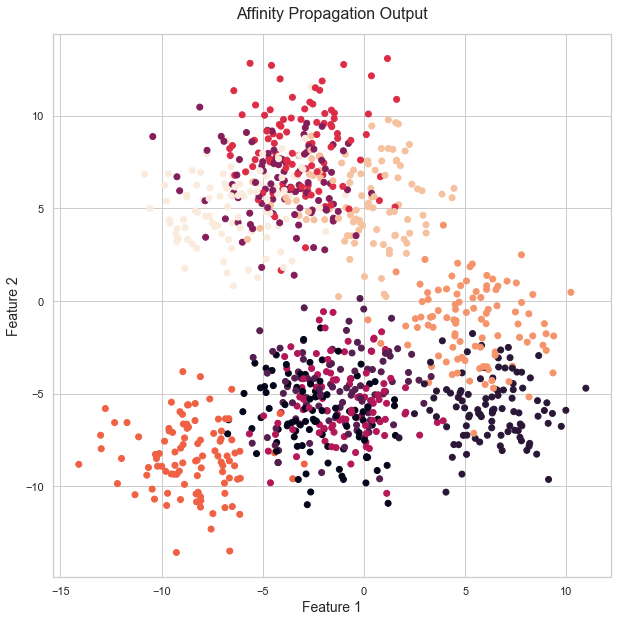

In [11]:
f.visualise(ap_output, "Affinity Propagation Output", "affinity_propagation.png")

In [12]:
# that's worse. It looks to have done a pretty poor job with clustering.

### Hierarchical (Agglomerative)

In [13]:
# Agglomerative creates a sort of tree as its output, and so it's really good at representing nested clusters.
# It's quite straightforward:
    # 1) Represent every data point as a cluster
    # 2) Merge the two closest clusters together to form a new cluster (and remove the two sub-clusters)
    # 3) Repeat step until you only have one cluster left
    
# This will give you the output of each cluster at the bottom row of a tree, and then a record of the order in which clusters
# were merged together. You can customise the logic behind how step 2 is run, but we'll get to that.

In [14]:
# the really key thing with Agglomerative Clustering is the strategy you use to merge clusters together. Remember that each
# cluster will (soon) have multiple datapoints in it.
    # single (minimum): merges the cluster pair with the smallest distance between their two closest data points
    # complete (maximum): merges the cluster pair with the smallest distance between their two most far apart data points
    # average: merges the clusters with the smallest average distance between datapoints
    # ward: merges the clusters that would result in the lowest total squared distance between all the new cluster's datapoints
        # and the cluster centre. (This metric is conceptually a lot like KMeans)

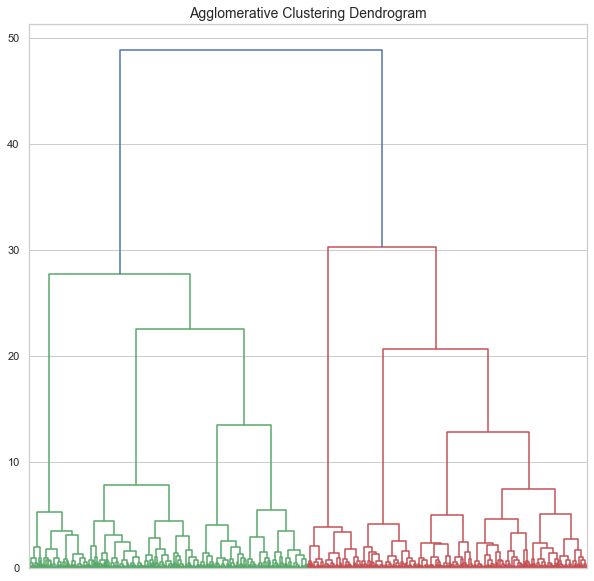

In [15]:
# we can show the process the clustering will follow with a dendrogram.
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_title("Agglomerative Clustering Dendrogram", size = 14)
Dendrogram = shc.dendrogram((shc.linkage(scaled, method ='ward')), no_labels = True, ax = ax)
plt.savefig(f"images/AgglomerativeClusteringDendrogram")
plt.show()

In [16]:
# it looks like it might be a good idea to have 5 clusters. Then we'll some nice granularity.
AG = AgglomerativeClustering(n_clusters=5,
                             affinity='euclidean', # how do we want to assess distance between datapoints?
                             memory=None, # this model is very intensive, do we want to cache it somewhere?
                             connectivity=None, # you can pass a matrix describing the distance between each point and its 
                                                # neighbours. This will make your clustering process much faster.
                             compute_full_tree='auto', # you can stop the clustering prematurely if you've defined n_clusters
                             linkage='ward', # see point above
                             distance_threshold=None) # how far away do points need to be before we don't group them?

In [17]:
results = AG.fit_predict(scaled)
AG_output = df.copy()
AG_output['label'] = results

score = silhouette_score(scaled, AG_output['label'])

print(AG)
print("silhouette_score score is "+str(round(score, 3)))

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)
silhouette_score score is 0.466


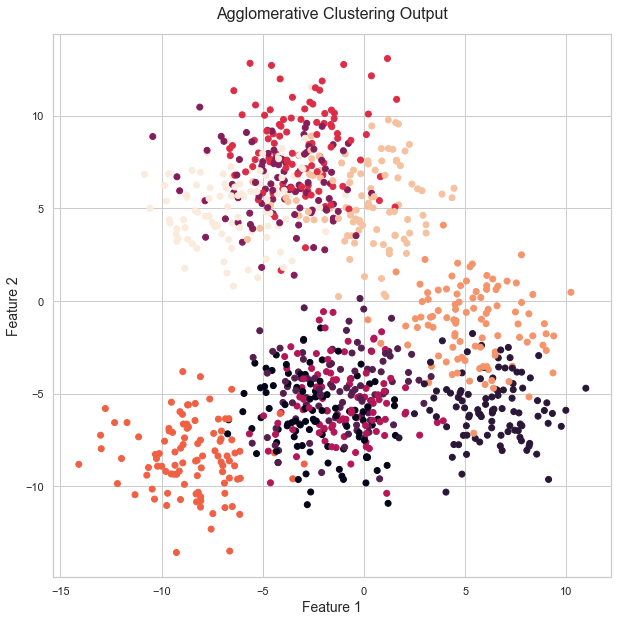

In [18]:
f.visualise(AG_output, "Agglomerative Clustering Output", "agglomerativeclusteringoutput.png")

### DBScan

In [19]:
# DBScan (Density-Based Spatial Clustering of Applications with Noise) is one I've not played around with a lot, but looks 
# really powerful. It focuses on density within your data, and builds clusters from there. The really important parameters are 
# 'how close do points need to be to be considered in the same neighbourhood', and 'how many points do you need in a 
# neighourhood for it to count as a cluster'. Like Affinity Propagation, you don't choose the number of clusters explicitly
# yourself. This model is weak when your clusters are of varying density (because you define eps universally)

dbscan = DBSCAN(eps=0.3, # how far apart can points be and still be in the same neighbourhood
                min_samples=15, # how many points does a neighbourhood need to be a cluster
                metric='euclidean') # standard as-the-crow-flies distance metric

results = dbscan.fit_predict(scaled)
db_output = df.copy()
db_output['label'] = results

score = silhouette_score(scaled, db_output['label'])

print(dbscan)
print("silhouette_score score is "+str(round(score, 3)))

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=15, n_jobs=None, p=None)
silhouette_score score is 0.368


In [20]:
f.visualise(db_output, "DBSCAN Clustering Result", "dbscan.png")